# Импортирање на потребните библиотеки

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize, grayscale_to_rgb
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

# Вчитување податоци

In [ ]:
# го вчитуваме податочното множество MNIST кое е составено од слики
# на цифри (0-9), цифрите претставуваат класи
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# за побрзо извршување на показните примери, користиме само дел
# од податочното множество
train_x, train_y = train_x[:2000], train_y[:2000]
test_x, test_y = test_x[:1000], test_y[:1000]

11501568/11490434 [==============================] - 0s 0us/step


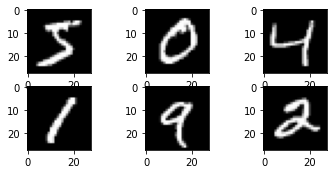

In [ ]:
# приказ на дел од сликите во податочното множество
for i in range(6):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
plt.show()

# Претпроцесирање на податоци

In [ ]:
# трансформација на вредностите за пикселите на сликите во реални броеви
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255

# додавање една дополнителна димензија на секоја слика
# за конзистентност со моделите
train_x = np.expand_dims(train_x, -1)
test_x = np.expand_dims(test_x, -1)

# промена на димензија на сликите (сите слики треба да имаат димензија 32x32)
train_x = resize(train_x, (32, 32))
test_x = resize(test_x, (32, 32))

# трансформација на сликите од црно-бели во боја
train_x = grayscale_to_rgb(train_x)
test_x = grayscale_to_rgb(test_x)

In [ ]:
# трансформација на класите во one-hot вектори
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

# VGG16

In [ ]:
# за класификација со моделот VGG16 потребно е да се креира објект
# кој ќе го претставува моделот, со следните аргументи
# include_top - дали да се вклучат целосно поврзаните слоеви
# weights - тежини со кои да се иницијализираат слоевите
# input_shape - димензија на влезните податоци
# classes - број на класи
vgg16 = VGG16(include_top=True, weights=None, input_shape=(32, 32, 3), classes=10)

# пред да се тренира, потребно е моделот да се компајлира
# со поставување на аргументот loss дефинираме категориска крос-ентропија
# како функција на загуба
# со поставување на аргументот optimizer дефинираме Adam оптимизатор со рата
# на учење еднаква на 0.01
# со поставување на аргументот metrics дефинираме точност како метрика за 
# следење на перформансите на моделот при тренирање
vgg16.compile(optimizer=Adam(learning_rate=0.01), loss=categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# при тренирање на моделот покрај влезните и излезните податоци, потребно е 
# да се постават вредности за аргументите epochs што претставува број на 
# епохи, batch_size што претставува големина на серија, validation_split што
# претставува колкав процент од податоците да се користат за валицација и
# опционално verbose со што се дефинира интензитет на информации за 
# процесот на тренирање
vgg16.fit(train_x, train_y, epochs=3, batch_size=1024, validation_split=0.2, verbose=2)

Epoch 1/3
2/2 - 61s - loss: 21.9629 - accuracy: 0.0919 - val_loss: 3.7001 - val_accuracy: 0.1050
Epoch 2/3
2/2 - 1s - loss: 3.3998 - accuracy: 0.1013 - val_loss: 2.3471 - val_accuracy: 0.0975
Epoch 3/3
2/2 - 1s - loss: 2.3599 - accuracy: 0.1025 - val_loss: 2.2997 - val_accuracy: 0.1150


In [ ]:
# евалуација на моделот со што се добиваат вредности за
# функцијата на загуба и точноста
vgg16.evaluate(test_x, test_y)

32/32 [==============================] - 1s 30ms/step - loss: 2.2994 - accuracy: 0.0940


[2.299438953399658, 0.09399999678134918]

# Трансфер на знаење

In [ ]:
# за класификација со трансфер на знаење со моделот VGG16 потребно е да 
# се креира објект кој ќе го претставува моделот, со следните аргументи
# include_top - дали да се вклучат целосно поврзаните слоеви
# weights - тежини со кои да се иницијализираат слоевите
# input_shape - димензија на влезните податоци
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# поставување на параметар кој означува дека слоевите од
# моделот VGG16 нема да се тренираат
base_model.trainable = False

# по излезниот слој од моделот VGG16 се додаваат слоеви
# според потребите на проблемот кој се разгледува
layer = base_model.output
layer = Flatten()(layer)
layer = Dense(256)(layer)
layer = Dropout(0.5)(layer)

# излезен слој за класата
output = Dense(10, activation='softmax')(layer)

# креирање објект кој ќе го претставува моделот со соодветните 
# влезни и излезни слоеви
model = Model(inputs=base_model.input, outputs=output)

# пред да се тренира, потребно е моделот да се компајлира
# со поставување на аргументот loss дефинираме категориска крос-ентропија
# како функција на загуба
# со поставување на аргументот optimizer дефинираме Adam оптимизатор со рата
# на учење еднаква на 0.01
# со поставување на аргументот metrics дефинираме точност како метрика за 
# следење на перформансите на моделот при тренирање
model.compile(optimizer=Adam(learning_rate=0.01), loss=categorical_crossentropy, metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# при тренирање на моделот покрај влезните и излезните податоци, потребно е 
# да се постават вредности за аргументите epochs што претставува број на 
# епохи, batch_size што претставува големина на серија, validation_split што
# претставува колкав процент од податоците да се користат за валицација и
# опционално verbose со што се дефинира интензитет на информации за 
# процесот на тренирање
model.fit(train_x, train_y, epochs=3, batch_size=1024, validation_split=0.2, verbose=2)

Epoch 1/3
2/2 - 2s - loss: 7.0592 - accuracy: 0.1331 - val_loss: 9.2747 - val_accuracy: 0.1025
Epoch 2/3
2/2 - 0s - loss: 8.6932 - accuracy: 0.1119 - val_loss: 6.1144 - val_accuracy: 0.0775
Epoch 3/3
2/2 - 0s - loss: 5.9867 - accuracy: 0.0938 - val_loss: 7.1894 - val_accuracy: 0.0475


In [ ]:
# евалуација на моделот со што се добиваат вредности за
# функцијата на загуба и точноста
model.evaluate(test_x, test_y)

32/32 [==============================] - 1s 18ms/step - loss: 7.4283 - accuracy: 0.0430


[7.428266525268555, 0.0430000014603138]